# Task 1: Acquire the data

In [1]:
import tensorflow as tf
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.jit as jit
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time

#load the data
fashion_mnist = tf.keras.datasets.fashion_mnist
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()
# flatten the images
fashion_train_images_vectorized=fashion_train_images.reshape(60000,784)
fashion_test_images_vectorized=fashion_test_images.reshape(10000,784)

#load the data
cifar10 = tf.keras.datasets.cifar10
(cifar10_train_images, cifar10_train_labels), (cifar10_test_images, cifar10_test_labels) = cifar10.load_data()

# flatten the images
cifar10_train_images_vectorized=cifar10_train_images.reshape(50000,3072)
cifar10_test_images_vectorized=cifar10_test_images.reshape(10000,3072)

Normalize the datasets.

In [3]:
# Define a function to normalize the datasets
def normalize(x):
    return (x.astype('float32')-np.mean(x))/np.std(x)

# Normalize all images for both datasets
fashion_train_images_normalized = normalize(fashion_train_images_vectorized)
fashion_test_images_normalized = normalize(fashion_test_images_vectorized)

cifar10_train_images_normalized = normalize(cifar10_train_images_vectorized)
cifar10_test_images_normalized = normalize(cifar10_test_images_vectorized)

We are going to one-hot encode our data because we have several classes for classification.

In [4]:
# one-hot encode train and test set labels
fashion_train_labels_one_hot = np.zeros((fashion_train_labels.size, int(fashion_train_labels.max()) + 1))
fashion_train_labels_one_hot[np.arange(fashion_train_labels.size),fashion_train_labels.astype(int)] = 1.0

fashion_test_labels_one_hot = np.zeros((fashion_test_labels.size, int(fashion_test_labels.max()) + 1))
fashion_test_labels_one_hot[np.arange(fashion_test_labels.size),fashion_test_labels.astype(int)] = 1.0

cifar10_train_labels_one_hot = np.zeros((cifar10_train_labels.size, int(cifar10_train_labels.max()) + 1))
cifar10_train_labels_one_hot[np.arange(cifar10_train_labels.size),cifar10_train_labels.astype(int)] = 1.0

cifar10_test_labels_one_hot = np.zeros((cifar10_test_labels.size, int(cifar10_test_labels.max()) + 1))
cifar10_test_labels_one_hot[np.arange(cifar10_test_labels.size),cifar10_test_labels.astype(int)] = 1.0

Import the data using pytorch for the CNN

In [5]:
# Define a transform to preprocess the data (you can customize this)
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader_CIFAR = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_CIFAR = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Download and load the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders to work with the data in batches
train_loader_MINST = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_MINST = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 79593115.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 26421880/26421880 [00:01<00:00, 18497149.26it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299230.34it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5480338.18it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18345180.11it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Task 2: Implement a Multilayer Perceptron

Define functions for later use:

In [6]:
from scipy.special import logsumexp

def softmax(x):
    e_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
    return np.nan_to_num(e_x/e_x.sum(axis=1,keepdims=True))

def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return (x > 0).astype(int)

In [7]:
class MiniBatchGradientDescent:

    def __init__(self, learning_rate=0.2,batch_size=1000, n_epochs=2, max_iters=1000, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.n_epochs = n_epochs

    def run(self, gradient_fn, x, y, weights, act_fn=ReLU):
        norms = np.array([np.inf])
        t = 1
        N, D = x.shape
        prev_weights = weights.copy()
        num_iterations = 0

        for epoch in range(self.n_epochs):
          # Create random mini-batches of given batch size
          shuffle = np.random.permutation(N)
          X_batches = np.array_split(x[shuffle],N/self.batch_size)
          Y_batches = np.array_split(y[shuffle],N/self.batch_size)

          # Iterate
          while np.any(norms > self.epsilon) and t < self.max_iters:
            for mini_batch_x, mini_batch_y in zip(X_batches, Y_batches):
              # Compute the gradient and update the weights
              grad = gradient_fn(mini_batch_x, mini_batch_y, weights)
              for p in range(len(weights)):
                  weights[p] -= self.learning_rate * grad[p]
              t += 1
              norms = np.array([np.linalg.norm(g) for g in grad])
        return weights

Definition of MLP model

In [8]:
class MLP:
  def __init__(self, activation_function, n_hidden_layers, units, K, add_bias=True, weight_init = 'Zero', regularization='No', reg_parameter=0.0001, batch_size = 16):
    self.activation_function = activation_function
    self.n_hidden_layers = n_hidden_layers
    self.units = units
    self.add_bias = add_bias
    self.weight_init = weight_init
    self.hidden = []
    self.weights = []
    self.regularization = regularization
    self.reg_parameter = reg_parameter
    self.K = K
    self.batch_size = batch_size
    self.optimizer = None

  def initialize_weights(self, dim_1, dim_2):
      # Intialize a weight layer given 2 dimensions and the weight initialization type.
      weights = []
      if self.weight_init == 'Zero':
        weights= np.zeros((dim_1, dim_2))
      elif self.weight_init == 'Gaussian':
        weights = np.random.normal(scale=0.1, size=(dim_1, dim_2))
      elif self.weight_init == 'Uniform':
        weights = np.random.uniform(-1, 1, size=(dim_1, dim_2))
      elif self.weight_init == 'Xavier':
        scale = 1/max(1., (2+2)/2.)
        limit = math.sqrt(3.0 * scale)
        weights = np.random.uniform(-limit, limit, size=(dim_1, dim_2))
      elif self.weight_init == 'Kaiming':
        limit = np.sqrt(6 / float(dim_1))
        weights = np.random.uniform(low=-limit, high=limit, size=(dim_1, dim_2))
      return weights

  def fit(self, x, y, learning_rate = 0.1, max_iterations = 1000, epsilon=1e-8):
      N,D = x.shape
      C = y.shape[0]

      if self.add_bias:
          # Stack a column of ones for bias
          x = np.column_stack([x,np.ones(N)])
          D+=1

      self.optimizer = MiniBatchGradientDescent(learning_rate=learning_rate, batch_size=self.batch_size, max_iters=max_iterations, epsilon = epsilon)

      if self.n_hidden_layers == 0:
          self.weights.append(self.initialize_weights(D, self.K))

      elif self.n_hidden_layers == 1:
        # Initialize weights
        self.weights.append(self.initialize_weights(D, self.units[0]))
        self.weights.append(self.initialize_weights(self.units[0], self.K))

      else:
        # Initialize weights
        self.weights.append(self.initialize_weights(D, self.units[0]))
        self.weights.append(self.initialize_weights(self.units[0], self.units[1]))
        self.weights.append(self.initialize_weights(self.units[1], self.K))


      def gradient(x2, y, params):
            dparams = []
            N2 = x2.shape[0]
            if(self.n_hidden_layers == 0):
                w = params[0]
                yh = softmax(np.dot(x2, w)) #N
                dy = yh - y
                dw = np.dot(x2.T, dy)/N2 #M
                if self.regularization=="L1":
                    dw[1:] += self.reg_parameter * np.sign(w[1:])
                elif self.regularization=="L2":
                    dw[1:] += self.reg_parameter * w[1:]
                dparams = [dw]

            if(self.n_hidden_layers == 1):
                v1, w = params
                z = self.activation_function[0](np.dot(x2, v1)) #N x M
                z = np.array(z, dtype=np.float64)
                if (np.abs(z).max() != 0):
                  z = z /  np.abs(z).max() * 2
                yh = softmax(np.dot(z, w))#N
                dy = yh - y
                dw = np.dot(z.T, dy)/N2 #M

                if self.regularization=="L1":
                    dw[1:] += self.reg_parameter * np.sign(w[1:])
                elif self.regularization=="L2":
                    dw[1:] += self.reg_parameter * w[1:]

                dz = np.dot(dy, w.T) #N x M
                dz = np.array(dz, dtype=np.float64)
                dv = np.dot(x2.T, dz * self.activation_function[1](z))/N2 #D x M

                if self.regularization == "L1":
                    dv[1:] += self.reg_parameter * np.sign(v1[1:])
                elif self.regularization == "L2":
                    dv[1:] += self.reg_parameter * v1[1:]

                dv = np.array(dv, dtype=np.float64)
                dparams = [dv, dw]

            if(self.n_hidden_layers == 2):
                v1, v2, w = params
                z1 = self.activation_function[0](np.dot(x2 , v1))
                z1 = z1 /  np.abs(z1).max() * 2
                z2 = self.activation_function[0](np.dot(z1, v2))

                yh = softmax(np.dot(z2, w))#N
                dy = yh - y #N
                dw = np.dot(z2.T, dy)/N2 #M

                if self.regularization=="L1":
                    dw[1:] += self.reg_parameter * np.sign(w[1:])
                elif self.regularization=="L2":
                    dw[1:] += self.reg_parameter * w[1:]

                dz2 = np.dot(dy, w.T) #N x M

                dv2 = np.dot(z1.T, dz2 * self.activation_function[1](z2))/N2 #M x M

                if self.regularization == "L1":
                    dv2[1:] += self.reg_parameter * np.sign(v2[1:])
                elif self.regularization == "L2":
                    dv2[1:] += self.reg_parameter * v2[1:]

                dz1 = np.dot(dz2, v2) * self.activation_function[1](z1)
                dv1 = np.dot(x2.T, dz1)/N2

                if self.regularization == "L1":
                    dv1[1:] += self.reg_parameter * np.sign(v1[1:])
                elif self.regularization == "L2":
                    dv1[1:] += self.reg_parameter * v1[1:]

                dparams = [dv1, dv2, dw]
            return dparams
      self.weights = self.optimizer.run(gradient, x, y, self.weights)
      return self

  def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
        yh = x
        for i in range(self.n_hidden_layers):
            yh = self.activation_function[0](np.dot(yh, self.weights[i]))
        return softmax(np.dot(yh, self.weights[-1]))

  def evaluate_accuracy(yh, y):
        correct_pred = 0
        total_pred = len(yh)
        for i in range(total_pred):
            if np.argmax(yh[i]) == y[i]:
                correct_pred += 1
        # Return number of correctly predicted instances over total number of instances
        return round(correct_pred / total_pred, 4)

# Task 3: Run experiments

## 3.1 Weight experiment

In [55]:
weight_init_test = ["Zero", "Uniform", "Gaussian", "Xavier", "Kaiming"]
times = []
accuracies = []
for weight_init in weight_init_test:
  mlp = MLP([ReLU, ReLU_derivative], 1, [128], 10, True, weight_init = weight_init)
  start_time = time.time()
  mlp.fit(fashion_train_images_normalized,fashion_train_labels_one_hot)
  end_time = time.time()
  acc = MLP.evaluate_accuracy(mlp.predict(fashion_test_images_normalized), fashion_test_labels)

  computation_time = round(end_time - start_time, 4)
  times.append(computation_time)
  accuracies.append(acc)
  print("Initializing weights with weight model "+ weight_init + " - Resulting Accuracy: " + str(acc) + " - Training time: "+ str(computation_time) + "s")

Initializing weights with weight model Zero - Resulting Accuracy: 0.1 - Training time: 10.049s
Initializing weights with weight model Uniform - Resulting Accuracy: 0.8522 - Training time: 8.3506s
Initializing weights with weight model Gaussian - Resulting Accuracy: 0.8399 - Training time: 11.6047s
Initializing weights with weight model Xavier - Resulting Accuracy: 0.844 - Training time: 12.2206s
Initializing weights with weight model Kaiming - Resulting Accuracy: 0.8356 - Training time: 5.952s


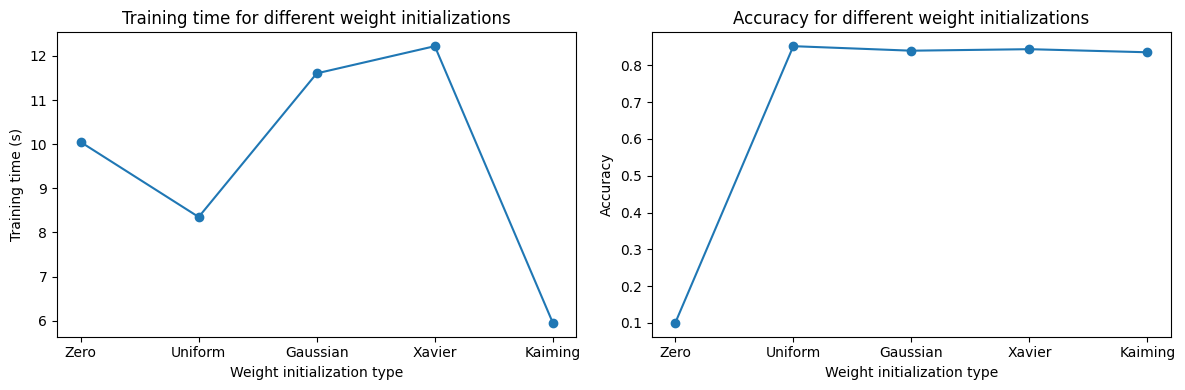

In [57]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(["Zero", "Uniform", "Gaussian", "Xavier", "Kaiming"], times, "-o")
plt.title("Training time for different weight initializations")
plt.ylabel("Training time (s)")
plt.xlabel("Weight initialization type")
plt.subplot(122)
plt.plot(["Zero", "Uniform", "Gaussian", "Xavier", "Kaiming"], accuracies, "-o")
plt.title("Accuracy for different weight initializations")
plt.ylabel("Accuracy")
plt.xlabel("Weight initialization type")
plt.tight_layout()
plt.show()

## 3.2 Network depth experiment

In [53]:
mlp_0 = MLP([ReLU, ReLU_derivative], 0, 0, 10, True, weight_init = "Gaussian")
mlp_1 = MLP([ReLU, ReLU_derivative], 1, [128], 10, True, weight_init = "Gaussian")
mlp_2 = MLP([ReLU, ReLU_derivative], 2, [128, 128], 10, True, weight_init = "Gaussian")

times = []
accuracies = []
for model, model_description in [(mlp_0, "MLP with no hidden layer"), (mlp_1, "MLP with 1 hidden layer having 128 units"), (mlp_2, "MLP with 2 hidden layers of 128 units")]:
    start_time = time.time()

    model.fit(fashion_train_images_normalized, fashion_train_labels_one_hot)
    end_time = time.time()

    acc = MLP.evaluate_accuracy(model.predict(fashion_test_images_normalized), fashion_test_labels)
    computation_time = round(end_time - start_time, 4)
    times.append(computation_time)
    accuracies.append(acc)
    print("Initializing weights with "+ model_description + " - Resulting Accuracy: " + str(acc) + " - Training time: "+ str(computation_time) + "s")


Initializing weights with MLP with no hidden layer - Resulting Accuracy: 0.8012 - Training time: 3.7403s
Initializing weights with MLP with 1 hidden layer having 128 units - Resulting Accuracy: 0.8359 - Training time: 7.2172s
Initializing weights with MLP with 2 hidden layers of 128 units - Resulting Accuracy: 0.8363 - Training time: 12.5237s


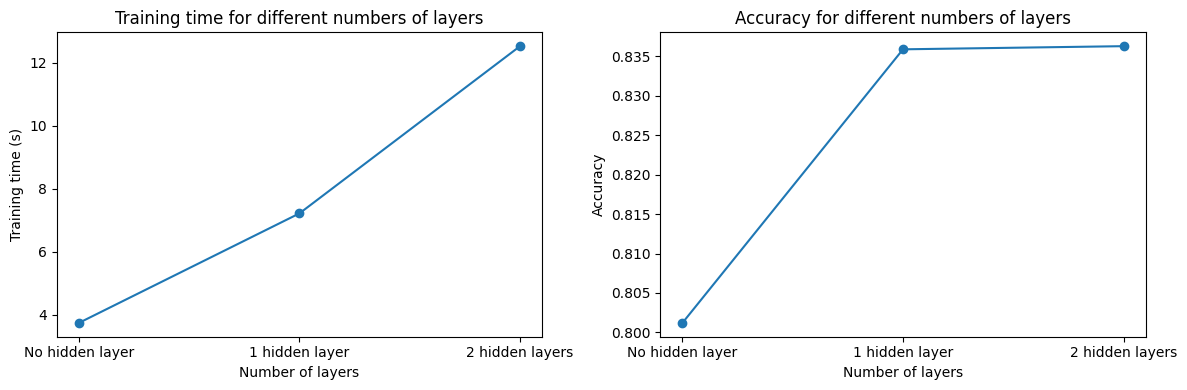

In [54]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(["No hidden layer", "1 hidden layer", "2 hidden layers"], times, "-o")
plt.title("Training time for different numbers of layers")
plt.ylabel("Training time (s)")
plt.xlabel("Number of layers")
plt.subplot(122)
plt.plot(["No hidden layer", "1 hidden layer", "2 hidden layers"], accuracies, "-o")
plt.title("Accuracy for different numbers of layers")
plt.ylabel("Accuracy")
plt.xlabel("Number of layers")
plt.tight_layout()
plt.show()

## 3.3 Activation function experiment

In [21]:
# Leaky ReLU
leaky_ReLU = lambda z, gamma=0.01: np.maximum(0., z) + gamma*np.minimum(0., z)
der_leaky_ReLU = lambda z, gamma=0.01: 1.0*(z > 0) + gamma*(z <= 0)

# Hyperbolic Tangent
logistic = lambda z: 1./ (1 + np.exp(-z))
tanh = lambda z: 2.*logistic(z)-1
der_tanh = lambda z: 1 - (tanh(z))**2

In [51]:
activation_function_test = [([ReLU, ReLU_derivative], "ReLU activation"), ([leaky_ReLU, der_leaky_ReLU], "Leaky ReLU activation"), ([tanh, der_tanh], "Hyperbolic Tangent activation")]
times = []
accuracies = []
for activation_function_list, description in activation_function_test:
  mlp = MLP(activation_function_list, 2, [128, 128], 10, True, weight_init = "Gaussian")
  start_time = time.time()

  mlp.fit(fashion_train_images_normalized, fashion_train_labels_one_hot)
  end_time = time.time()

  acc = MLP.evaluate_accuracy(mlp.predict(fashion_test_images_normalized), fashion_test_labels)
  computation_time = round(end_time - start_time, 4)
  times.append(computation_time)
  accuracies.append(acc)
  print("Initializing model with "+ description + " - Resulting Accuracy: " + str(acc) + " - Training time: "+ str(computation_time) + "s")


Initializing model with ReLU activation - Resulting Accuracy: 0.8326 - Training time: 6.901s
Initializing model with Leaky ReLU activation - Resulting Accuracy: 0.8323 - Training time: 8.4997s
Initializing model with Hyperbolic Tangent activation - Resulting Accuracy: 0.8397 - Training time: 9.0342s


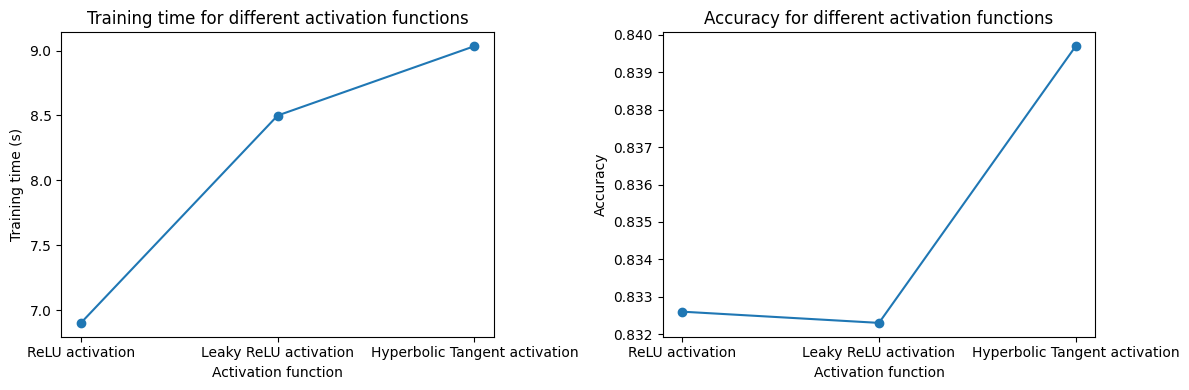

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(["ReLU activation", "Leaky ReLU activation", "Hyperbolic Tangent activation"], times, "-o")
plt.title("Training time for different activation functions")
plt.ylabel("Training time (s)")
plt.xlabel("Activation function")
plt.subplot(122)
plt.plot(["ReLU activation", "Leaky ReLU activation", "Hyperbolic Tangent activation"], accuracies, "-o")
plt.title("Accuracy for different activation functions")
plt.ylabel("Accuracy")
plt.xlabel("Activation function")
plt.tight_layout()
plt.show()

## 3.4 Regularization experiment

In [38]:
regularization = [("No", "No regularization"), ("L1", "L1 regularization"), ("L2", "L2 regularization")]
times = []
accuracies = []
for reg_type, description in regularization:
  mlp = MLP([ReLU, ReLU_derivative], 2, [128, 128], 10, True, weight_init = "Gaussian", regularization=reg_type)
  start_time = time.time()

  mlp.fit(fashion_train_images_normalized, fashion_train_labels_one_hot)
  end_time = time.time()

  acc = MLP.evaluate_accuracy(mlp.predict(fashion_test_images_normalized), fashion_test_labels)
  computation_time = round(end_time - start_time, 4)
  times.append(computation_time)
  accuracies.append(acc)
  print("Regularization type: " + description + " - Resulting Accuracy: " + str(acc) + " - Training time: "+ str(computation_time) + "s")


Regularization type: No regularization - Resulting Accuracy: 0.7866 - Training time: 8.0909s
Regularization type: L1 regularization - Resulting Accuracy: 0.8234 - Training time: 9.3773s
Regularization type: L2 regularization - Resulting Accuracy: 0.837 - Training time: 9.3225s


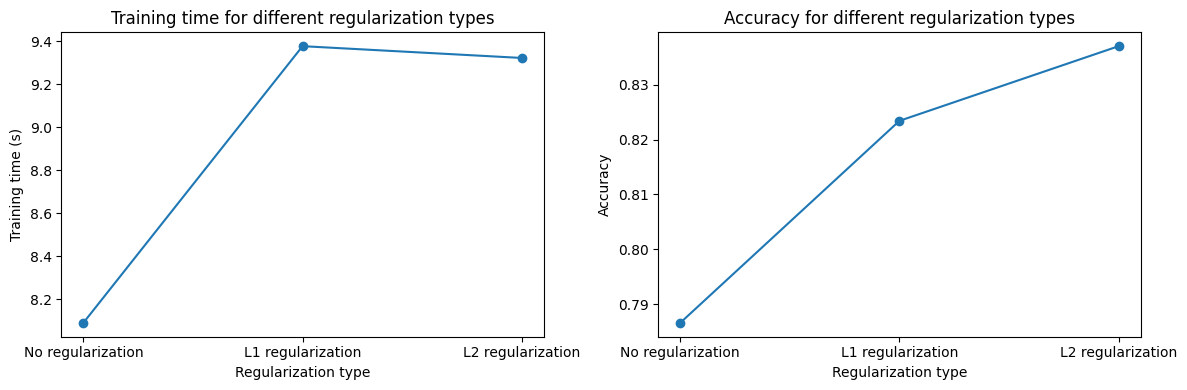

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(["No regularization", "L1 regularization", "L2 regularization"], times, "-o")
plt.title("Training time for different regularization types")
plt.ylabel("Training time (s)")
plt.xlabel("Regularization type")
plt.subplot(122)
plt.plot(["No regularization", "L1 regularization", "L2 regularization"], accuracies, "-o")
plt.title("Accuracy for different regularization types")
plt.ylabel("Accuracy")
plt.xlabel("Regularization type")
plt.tight_layout()
plt.show()

## 3.5 Training with unnormalized images experiment

In [25]:
mlp = MLP([ReLU, ReLU_derivative], 2, [128, 128], 10, True, weight_init = "Gaussian")
start_time = time.time()

mlp.fit(fashion_train_images_vectorized, fashion_train_labels_one_hot)
end_time = time.time()

acc = MLP.evaluate_accuracy(mlp.predict(fashion_test_images_vectorized), fashion_test_labels)

print("Training with unnormalized images - Resulting Accuracy: " + str(acc) + " - Training time: "+ str(round(end_time - start_time, 4)) + "s")

Training with unnormalized images - Resulting Accuracy: 0.8204 - Training time: 9.7181s


## 3.6 Create a CNN

In [31]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 10
    model.train()
    start_time = time.time()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch: {} - Accuracy: {:.3f}% - Loss: {:.4f}'.format(
                    epoch + 1, float(correct*100) / float(64*(batch_idx+1)), loss.item()))

    end_time = time.time()
    print("Time for ", EPOCHS, " epochs: ", end_time - start_time)

def evaluate(model, test_loader):
    correct = 0
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*64)))

In [10]:
class CNN_MINST(nn.Module):
    def __init__(self):
        super(CNN_MINST, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=128)
        self.out = nn.Linear(in_features=128,out_features=10)

    def forward(self,x):
      #input layer
      x = x
      #first hidden layer
      x = self.conv1(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x,kernel_size=2,stride=2)
      #second hidden layer
      x = self.conv2(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x,kernel_size=2,stride=2)
      #third hidden layer
      x = x.reshape(-1,12*4*4)
      x = self.fc1(x)
      x = nn.functional.relu(x)
      #fourth hidden layer
      x = self.fc2(x)
      x = nn.functional.relu(x)

      #output layer
      x = self.out(x)
      return x


In [32]:
model_MINST = CNN_MINST()

fit(model_MINST, train_loader_MINST)

Epoch: 1 - Accuracy: 7.812% - Loss: 2.3036
Epoch: 1 - Accuracy: 39.798% - Loss: 0.9797
Epoch: 1 - Accuracy: 52.305% - Loss: 0.7639
Epoch: 1 - Accuracy: 57.875% - Loss: 0.6268
Epoch: 1 - Accuracy: 61.746% - Loss: 0.7736
Epoch: 1 - Accuracy: 64.038% - Loss: 0.5919
Epoch: 1 - Accuracy: 65.755% - Loss: 0.7645
Epoch: 1 - Accuracy: 67.183% - Loss: 0.6673
Epoch: 1 - Accuracy: 68.317% - Loss: 0.5325
Epoch: 1 - Accuracy: 69.076% - Loss: 0.4899
Epoch: 1 - Accuracy: 69.929% - Loss: 0.6714
Epoch: 1 - Accuracy: 70.690% - Loss: 0.5949
Epoch: 1 - Accuracy: 71.329% - Loss: 0.5694
Epoch: 1 - Accuracy: 71.909% - Loss: 0.6227
Epoch: 1 - Accuracy: 72.414% - Loss: 0.5911
Epoch: 1 - Accuracy: 72.909% - Loss: 0.4361
Epoch: 1 - Accuracy: 73.338% - Loss: 0.4936
Epoch: 1 - Accuracy: 73.766% - Loss: 0.5851
Epoch: 1 - Accuracy: 74.204% - Loss: 0.4258
Epoch: 2 - Accuracy: 78.125% - Loss: 0.4847
Epoch: 2 - Accuracy: 81.863% - Loss: 0.5775
Epoch: 2 - Accuracy: 81.946% - Loss: 0.3422
Epoch: 2 - Accuracy: 82.088% - Lo

In [111]:
evaluate(model_MINST, test_loader_MINST)

Test accuracy:0.867% 


## 3.7 Train an MLP for CIFAR-10.

In [25]:
mlp = MLP([ReLU, ReLU_derivative], 1, [128], 10, True, weight_init = "Gaussian")

mlp.fit(cifar10_train_images_normalized, cifar10_train_labels_one_hot)

acc = MLP.evaluate_accuracy(mlp.predict(cifar10_test_images_normalized), cifar10_test_labels)

print("MLP for CIFAR10 - Resulting Accuracy: " + str(acc))

MLP for CIFAR10 - Resulting Accuracy: 0.111


In [29]:
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128,out_features=10)

    def forward(self, x):
      #input layer
      x = x
      #first hidden layer
      x = self.conv1(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x,kernel_size=2,stride=2)
      #second hidden layer
      x = self.conv2(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x,kernel_size=2,stride=2)
      #third hidden layer
      x = x.reshape(-1,32 * 8 * 8)
      x = self.fc1(x)
      x = nn.functional.relu(x)
      #fourth hidden layer
      x = self.fc2(x)
      x = nn.functional.relu(x)

      #output layer
      x = self.out(x)
      return x


In [33]:
model_CIFAR = CNN_CIFAR()

fit(model_CIFAR, train_loader_CIFAR)

Epoch: 1 - Accuracy: 10.938% - Loss: 2.2998
Epoch: 1 - Accuracy: 12.898% - Loss: 2.1443
Epoch: 1 - Accuracy: 18.843% - Loss: 1.8341
Epoch: 1 - Accuracy: 23.965% - Loss: 1.7219
Epoch: 1 - Accuracy: 27.550% - Loss: 1.7513
Epoch: 1 - Accuracy: 29.806% - Loss: 1.6254
Epoch: 1 - Accuracy: 32.003% - Loss: 1.4473
Epoch: 1 - Accuracy: 33.369% - Loss: 1.6346
Epoch: 1 - Accuracy: 34.722% - Loss: 1.2988
Epoch: 1 - Accuracy: 35.619% - Loss: 1.5602
Epoch: 1 - Accuracy: 36.636% - Loss: 1.5124
Epoch: 1 - Accuracy: 37.503% - Loss: 1.7134
Epoch: 1 - Accuracy: 38.410% - Loss: 1.6417
Epoch: 1 - Accuracy: 39.245% - Loss: 1.6127
Epoch: 1 - Accuracy: 40.019% - Loss: 1.4262
Epoch: 1 - Accuracy: 40.689% - Loss: 1.3290
Epoch: 2 - Accuracy: 57.812% - Loss: 1.2569
Epoch: 2 - Accuracy: 52.727% - Loss: 1.4699
Epoch: 2 - Accuracy: 52.847% - Loss: 1.4207
Epoch: 2 - Accuracy: 52.918% - Loss: 1.3506
Epoch: 2 - Accuracy: 52.511% - Loss: 1.3239
Epoch: 2 - Accuracy: 52.727% - Loss: 1.2178
Epoch: 2 - Accuracy: 52.596% - L

In [34]:
evaluate(model_CIFAR, test_loader_CIFAR)

Test accuracy:0.677% 


## 3.8 Investigate the effect of optimizer on performance

# 3.9 Bonus: Pre-trained model

In [3]:
#Task 2 Part 9:

from torchvision import models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Initializing model and setting default weights.
weights=models.ResNet18_Weights.DEFAULT
resnet=models.resnet18(models.ResNet18_Weights.DEFAULT)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#Removing FC layers.
num_In=resnet.fc.in_features
resnet.fc=None

#Freezing convolutional ayers.
for param in resnet.parameters():
    param.requires_grad=False
    
#Adding new FC layers.
classifier = nn.Sequential(
    nn.Linear(num_In, 1024),  
    nn.ReLU(inplace=True), 
    nn.Linear(1024, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    #nn.Softmax(dim=1)
    nn.ReLU(inplace=True),  
    #nn.Dropout(0.25),  
    nn.Linear(512, 10),
    #nn.ReLU(inplace=True), 
    #nn.Dropout(0.25),  
    #nn.Linear(256, 10),
    #nn.ReLU(inplace=True), 
    #nn.Dropout(0.25),  
    #nn.Linear(128, 10)
)

resnet.fc=classifier

for param in resnet.fc.parameters():
    param.requires_grad=True
    
#Training the model
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001,
                      momentum=0.95, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

cifar_Train=torchvision.datasets.CIFAR10("C://Users//Shiyan Liu//Documents//GitHub//COMP-_551_A2//A2", download=True, 
                                     train=True, transform=transform_train)


num_Epochs=20
loss_Function=nn.CrossEntropyLoss()
cifar_Data= DataLoader(cifar_Train, batch_size=128, shuffle=True)

n=0
lossArr=[]
num_Iterations=len(cifar_Data)
scheduler_Step=scheduler.T_max/num_Iterations
i=0

epoch_Time=0
while n<num_Epochs:
    resnet.train()
    cur=time.time()
    for batch in cifar_Data:
        
        print(batch)
        outputs = resnet(batch[0]) # Forward pass
        loss = loss_Function(outputs, batch[1])  
                
        optimizer.zero_grad()
        lossArr.append(loss.item())
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        scheduler.step()
    if n==1:
        epoch_Time=time.time()-cur
    n+=1
    
print("Done Testing")

plt.plot(range(len(lossArr)), lossArr)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch for Resnet18 Model with 1 Added FC Layer on Cifar-10 Dataset")
plt.show()

print("Time for one epoch is", epoch_Time)

cifar_Test=torchvision.datasets.CIFAR10("C://Users//Shiyan Liu//Documents//GitHub//COMP-_551_A2//A2", download=True, 
                                    train=False, transform=transform_train)

cifar_Test_Data=DataLoader(cifar_Test, batch_size=1, shuffle=True)

resnet.eval()
tot=0

i=0
for batch in cifar_Test_Data:
    print(batch)
    if i>2000:
        break
    i+=1
    image, label = batch
    prediction = resnet(image).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    if class_id-label==0:
        tot+=1
    
print("Accuracy after 2000 test set images is:", round(tot/(i+1),3))

C:\Users\Shiyan Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Files already downloaded and verified
[tensor([[[[-0.4906, -0.5293, -0.4712,  ..., -2.4291, -2.4291, -2.4291],
          [-0.2967, -0.3355, -0.3936,  ..., -2.4291, -2.4291, -2.4291],
          [-0.3355, -0.1804, -0.3355,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-0.0835, -0.1029, -0.5293,  ..., -2.4291, -2.4291, -2.4291],
          [-0.9364, -0.7232, -0.8201,  ..., -2.4291, -2.4291, -2.4291],
          [-1.3047, -1.1884, -0.8395,  ..., -2.4291, -2.4291, -2.4291]],

         [[ 0.6498,  0.6694,  0.7284,  ..., -2.4183, -2.4183, -2.4183],
          [ 0.6891,  0.7284,  0.7678,  ..., -2.4183, -2.4183, -2.4183],
          [ 0.4334,  0.7481,  0.8071,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-0.3926, -0.3926, -0.7466,  ..., -2.4183, -2.4183, -2.4183],
          [-1.2579, -1.0219, -1.0022,  ..., -2.4183, -2.4183, -2.4183],
          [-1.6709, -1.4742, -1.0022,  ..., -2.4183, -2.4183, -2.4183]],

         [[ 1.6026,  1.7002,  1.8172,  ..., -2.2214, -2.2214, -

KeyboardInterrupt: 